In [1]:
from kaggle_handler import handler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Handling Missing Data
- Complete Case Analysis (Remove NaN Row/Columns)
- Imputing NaN Cells
  - Univariate
    - Numaric
      - Mean/Medain
      - Automatically Select Value For Imputation (Grid Search CV)
      - Arbitary
      - End of Distribution
      - Random
      - Missing Indicater
    - Catagorical
      - Mode
      - Create New Category
      - Missing Indicater
  - Multivarte
    - KNN Impute
    - Iterative Impute

# Complete Case Analysis (CCA)

    Complete Case Analysis (CNN), also called "list-wise deletion" of case, consists in discarding observations (row) where values in any of the variables (columns) are missing
    
    CCA means literally analyzio\ng only those abservations for which there is information in all of the variables in the dataset

- Assumption for CCA
  1) Missing Completaly at Random (MCAR)
- Point to Check after CCA
  1) Distribution of data should not change much
  2) Ratio of the set should not change much

In [3]:
Assets = handler()

Directory 'Assets' already exists.
Datasets already exist in Assets folder
['lung_cancer_prediction_dataset.csv', 'Titanic-Dataset.csv', 'GenZ_DatingApp_Data.csv', 'concrete_data.csv']
 Change Add_more parameter to download more datasets


In [4]:
df = pd.read_csv('Assets/Titanic-Dataset.csv', index_col='PassengerId')
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
565,0,3,"Meanwell, Miss. (Marion Ogden)",female,NaN,0,0,SOTON/O.Q. 392087,8.0500,NaN,S
65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
406,0,2,"Gale, Mr. Shadrach",male,34.0,1,0,28664,21.0000,NaN,S
238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,C.A. 31921,26.2500,NaN,S


In [5]:
# Making some cells Nan for Batter understanding
random = df['Pclass'].sample(35)
for ind in random.index:
    df.loc[ind,'Pclass'] = np.nan
random = df['Pclass'][df['Age'].isna()].sample(10)
for ind in random.index:
    df.loc[ind,'Pclass'] = np.nan 

In [6]:
np.round(df.isna().sum()/df.shape[0]*100,2)

Survived     0.00
Pclass       4.94
Name         0.00
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       77.10
Embarked     0.22
dtype: float64

    Not Concidring Cabin Column Because To Many NaN Values

In [7]:
CCA_Data = df[['Pclass','Age','Embarked']].copy()
CCA_Data.shape

(891, 3)

In [8]:
CCA_Data.sample(5)

,Pclass,Age,Embarked
PassengerId,,,
889,3.0,NaN,S
248,2.0,24.0,S
480,3.0,2.0,S
641,3.0,20.0,S
337,1.0,29.0,S


## Orignal Ratio with NuN Values

In [9]:
OR = np.round(CCA_Data.count()/CCA_Data.shape[0]*100,2)
OR

Pclass      95.06
Age         80.13
Embarked    99.78
dtype: float64

## Ratio With Zero NuN Values in Pclass

In [10]:
CCA_Data_Pclass_droped = CCA_Data.dropna(subset=['Pclass'])
CCA_Data_Pclass_droped.shape

(847, 3)

In [11]:
Pclass_Ratio = np.round(CCA_Data_Pclass_droped.count()/CCA_Data_Pclass_droped.shape[0]*100,2)
Pclass_Ratio

Pclass      100.00
Age          80.87
Embarked     99.76
dtype: float64

### Chnage in Ratio With Respect to Original Ratio

In [12]:
OR - Pclass_Ratio

Pclass     -4.94
Age        -0.74
Embarked    0.02
dtype: float64

## Ratio With Zero NuN Values in Age

In [13]:
CCA_Data_Age_droped = CCA_Data.dropna(subset=['Age'])
CCA_Data_Age_droped.shape

(714, 3)

In [14]:
Age_ratio = np.round(CCA_Data_Age_droped.count()/CCA_Data_Age_droped.shape[0]*100,2)
Age_ratio

Pclass       95.94
Age         100.00
Embarked     99.72
dtype: float64

### Chnage in Ratio With Respect to Original Ratio

In [15]:
OR - Age_ratio

Pclass      -0.88
Age        -19.87
Embarked     0.06
dtype: float64

## Ratio With Zero NuN Values in Embarked

In [16]:
CCA_Data_Embarked_droped = CCA_Data.dropna(subset=['Embarked'])
CCA_Data_Embarked_droped.shape

(889, 3)

In [17]:
Embarked_ratio = np.round(CCA_Data_Embarked_droped.count()/CCA_Data_Embarked_droped.shape[0]*100,2)
Embarked_ratio

Pclass       95.05
Age          80.09
Embarked    100.00
dtype: float64

### Chnage in Ratio With Respect to Original Ratio

In [18]:
OR - Embarked_ratio

Pclass      0.01
Age         0.04
Embarked   -0.22
dtype: float64

## Function to Moniter the Change in Distribution and Ratio Due to CCA

In [19]:
def CCA_Ratio_Distribution(OR,data,feald):
    droped = data.dropna(subset=feald)
    ratio = np.round(droped.count()/droped.shape[0]*100,2)
    plt.figure(figsize=(12,4))
    ss = StandardScaler()
    new_data1 = ss.fit_transform(data[data.describe().columns])
    for i, col in enumerate(data.describe().columns):
        sns.kdeplot(new_data1[:,i], label=f'{col} Before CCA')

    new_data2 = ss.transform(droped[data.describe().columns])
    for i, col in enumerate(droped.describe().columns):
        sns.kdeplot(new_data2[:,i], label=f'{col} After CCA')
        plt.legend()
    plt.show()
    return OR - ratio

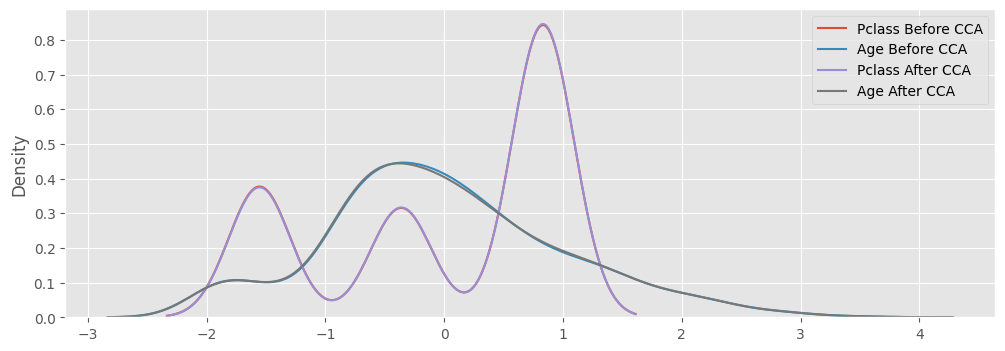

Pclass     -4.94
Age        -0.70
Embarked   -0.22
dtype: float64

In [20]:
CCA_Ratio_Distribution(OR,CCA_Data,['Pclass','Embarked'])

        Since we are facing a great loss in distribution while performing CCA on the 'Age' column, we reject the 'Age' column and conclude that the column combination of 'Pclass' and 'Embarked' is the best combination for CCA.

# Handling Missing Numarical Data
- Univariate Imputation
  - Mean / Median
  - Automatically Select Value For Imputation (Grid Search CV)
  - Arbitrary
  - End of Distribution
  - Random
  - Missing Indicater
- Multivarte Imputation
  - KNN Imputer
  - Multivariate Imputation by Chained Equations (MICE)

## Univariate Imputation

    Univariate Imputation is Imputing methods where we analyse and impute in a perticular column at a time 

### Mean / Median
- Simple to Impliment
- Work best if less then 5% data is missing
- Changes the distribution shape
- Create outliers which might not be a outliers before
- Change the covariance and Corelation of data

In [21]:
Mean_Median_Data = df[['Pclass','Age']].copy()
Mean_Median_Data.sample(3)

,Pclass,Age
PassengerId,,
756,2.0,0.67
175,1.0,56.00
317,2.0,24.00


#### Imputing in Pclass

In [22]:
si = SimpleImputer(strategy='mean')
Mean_Replaced = Mean_Median_Data[['Age']]
Mean_Replaced['Pclass'] = si.fit_transform(Mean_Median_Data[['Pclass']])

#### Comparing the change in imputed data

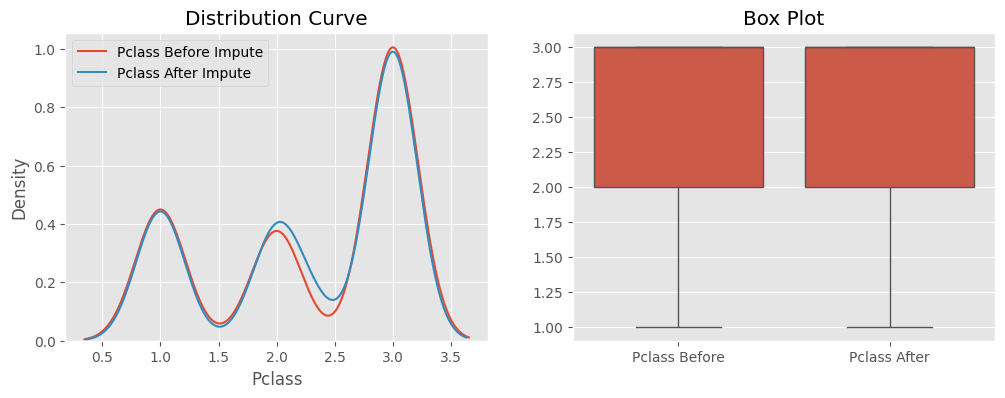

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.kdeplot(Mean_Median_Data['Pclass'], label='Pclass Before Impute')
sns.kdeplot(Mean_Replaced['Pclass'], label='Pclass After Impute')
plt.title('Distribution Curve')
plt.legend()

plt.subplot(122)
sns.boxplot({'Pclass Before':Mean_Median_Data['Pclass']})
sns.boxplot({'Pclass After':Mean_Replaced['Pclass']})
plt.title('Box Plot')

plt.show()

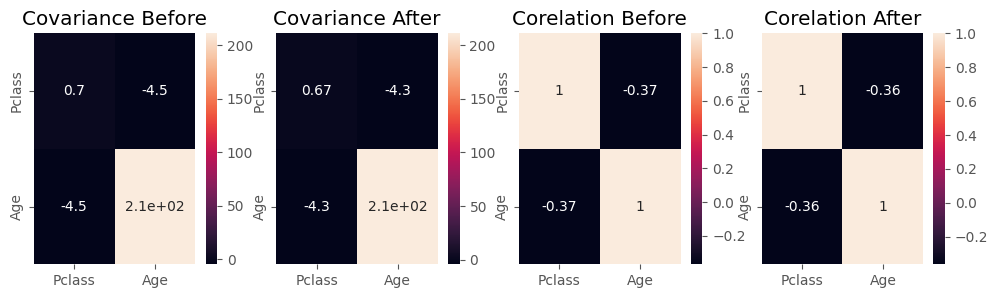

In [24]:
plt.figure(figsize=(12,3))
plt.subplot(141)
sns.heatmap(Mean_Median_Data[Mean_Median_Data.describe().columns].cov(),annot=True)
plt.title("Covariance Before")
plt.subplot(142)
sns.heatmap(Mean_Replaced[Mean_Median_Data.describe().columns].cov(),annot=True)
plt.title("Covariance After")
plt.subplot(143)
sns.heatmap(Mean_Median_Data[Mean_Median_Data.describe().columns].corr(),annot=True)
plt.title("Corelation Before")
plt.subplot(144)
sns.heatmap(Mean_Replaced[Mean_Median_Data.describe().columns].corr(),annot=True)
plt.title("Corelation After")

plt.show()

#### Defining Function to Impute Mean / Median and Moniter It's impacts

In [25]:
def Mean_Medain_Impute(data:pd.DataFrame,colls:(list,pd.Series,np.array),Impute:(list,pd.Series,np.array)):
    if len(colls)!=len(Impute):
        raise ValueError('ERROR: Length of columns is not equal to the Impute method mentioned')
    new_data = data[[col for col in data.columns if col not in colls]]
    for col, methed in zip(colls,Impute):
        si = SimpleImputer(strategy=methed)
        new_data[col] = si.fit_transform(data[[col]])

    
    ss = StandardScaler()
    old_scaled = ss.fit_transform(data[colls])
    new_scaled = ss.transform(new_data[colls])
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    for i, coll in enumerate(colls):
        sns.kdeplot(old_scaled[:,i], label=f'{coll} before')
        sns.kdeplot(new_scaled[:,i], label=f'{coll} after')
    plt.title('Distribution Curve')
    plt.legend()
    
    plt.subplot(122)
    for i, coll in enumerate(colls):
        sns.boxplot({f'{coll} before': old_scaled[:,i]})
        sns.boxplot({f'{coll} after':new_scaled[:,i]})
    plt.title('Box Plot')

    plt.show()

    
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    sns.heatmap(data[data.columns].cov(),annot=True)
    plt.title("Covariance Before")
    plt.subplot(142)
    sns.heatmap(new_data[data.columns].cov(),annot=True)
    plt.title("Covariance After")
    plt.subplot(143)
    sns.heatmap(data[data.columns].corr(),annot=True)
    plt.title("Corelation Before")
    plt.subplot(144)
    sns.heatmap(new_data[data.columns].corr(),annot=True)
    plt.title("Corelation After")
    
    plt.show()

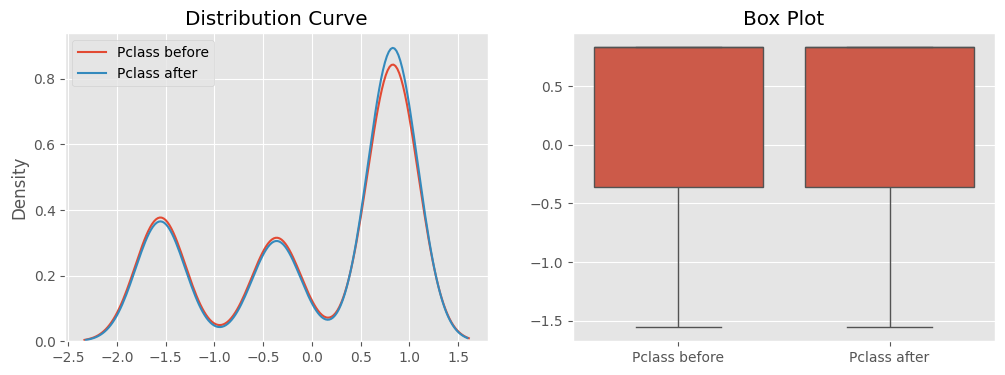

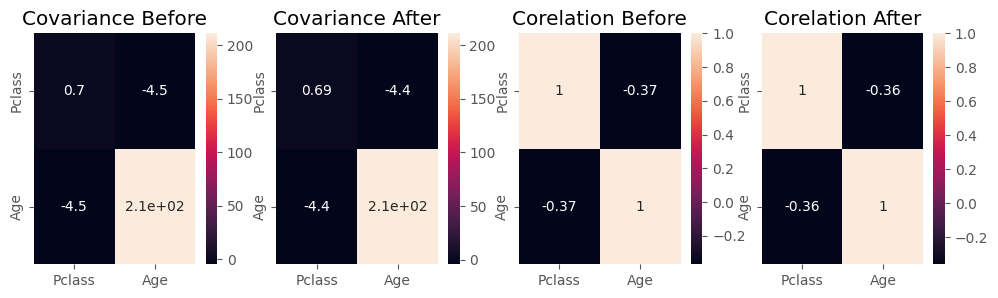

In [26]:
Mean_Medain_Impute(Mean_Median_Data,['Pclass'],['median'])

    As Age columns is creating so much noice we reject the Age imputation and accept only Pclass imputation with Median value 

### Automatically Select Value For Imputation (Grid Search CV)
- Use to find best combination of values
- Grid Search CV loop through different combinations to find best one
- Slow (long run time)
- Not memory efficient

#### Creating Machine Learning Mode

In [27]:
GSCV_Data = df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
GSCV_Data.shape

(891, 8)

In [28]:
np.round(GSCV_Data.isna().sum()/GSCV_Data.shape[0]*100,2)

Survived     0.00
Pclass       4.94
Sex          0.00
Age         19.87
SibSp        0.00
Parch        0.00
Fare         0.00
Embarked     0.22
dtype: float64

In [29]:
X = GSCV_Data.drop(columns=['Survived'])
y = GSCV_Data.Survived

In [30]:
X.sample(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
88,NaN,male,NaN,0,0,8.0500,S
470,3.0,female,0.75,2,1,19.2583,C
130,3.0,male,45.00,0,0,6.9750,S


In [31]:
X.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [32]:
ct1 = ColumnTransformer(transformers=[
    ('sm_Pclass', SimpleImputer(strategy='mean'), [0]),
    ('sm_Age', SimpleImputer(strategy='median'), [2]),
    ('sm_Embarked', SimpleImputer(strategy='constant'), [6])
],remainder='passthrough')

ct2 = ColumnTransformer(transformers=[
    ('ss',StandardScaler(),[0,1,4,5,6]),
    ('ohe',OneHotEncoder(drop='first'),[3,2])
],remainder='passthrough')

In [33]:
lr = LogisticRegression()
pipline = Pipeline([
    ('ms_stage',ct1),
    ('ss_ohe_stage',ct2),
    ('model',lr)
])

#### Grid Search CV

In [34]:
param_grid = {
    'ms_stage__sm_Pclass__strategy': ['mean','median','constant','most_frequent'],
    'ms_stage__sm_Age__strategy': ['mean','median','constant','most_frequent'],
    'ms_stage__sm_Embarked__strategy': ['constant','most_frequent'],
}
GSCV = GridSearchCV(estimator=pipline,param_grid=param_grid,cv=30)

In [35]:
GSCV.fit(X,y)

GridSearchCV(cv=30,
             estimator=Pipeline(steps=[('ms_stage',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('sm_Pclass',
                                                                         SimpleImputer(),
                                                                         [0]),
                                                                        ('sm_Age',
                                                                         SimpleImputer(strategy='median'),
                                                                         [2]),
                                                                        ('sm_Embarked',
                                                                         SimpleImputer(strategy='constant'),
                                                                         [6])])),
                                       ('ss_ohe_stage',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          4, 5,
                                                                          6]),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         [3,
                                                                          2])])),
                                       ('model', LogisticRegression())]),
             param_grid={'ms_stage__sm_Age__strategy': ['mean', 'median',
                                                        'constant',
                                                        'most_frequent'],
                         'ms_stage__sm_Embarked__strategy': ['constant',
                                                             'most_frequent'],
                         'ms_stage__sm_Pclass__strategy': ['mean', 'median',
                                                           'constant',
                                                           'most_frequent']})

In [36]:
pd.DataFrame(GSCV.best_params_, index=[1])

,ms_stage__sm_Age__strategy,ms_stage__sm_Embarked__strategy,ms_stage__sm_Pclass__strategy
1,median,most_frequent,mean


In [37]:
GSCV.best_score_.round(2)

np.float64(0.8)

### Arbitrary
- Replace with somthing which's not in data
- Workes best when data is missing not at random
- Change the distribution shape
- Create the outliers which might not be a outliers before
- Change in Covariance and Corelation

In [38]:
Arbitrary_data = df[['Age','Pclass']]
Arbitrary_data.shape

(891, 2)

In [39]:
np.round(Arbitrary_data.isna().sum()/Arbitrary_data.shape[0]*100,2)

Age       19.87
Pclass     4.94
dtype: float64

#### Perfomaing Arbitrary Imputing in Pclass Column

In [40]:
Arbitrary_data['Pclass'].unique()

array([ 3.,  1.,  2., nan])

In [41]:
Imputed_Data = Arbitrary_data[['Age']]
Imputed_Data['Pclass'] = Arbitrary_data[['Pclass']].fillna(-10)

#### Comparing The Output

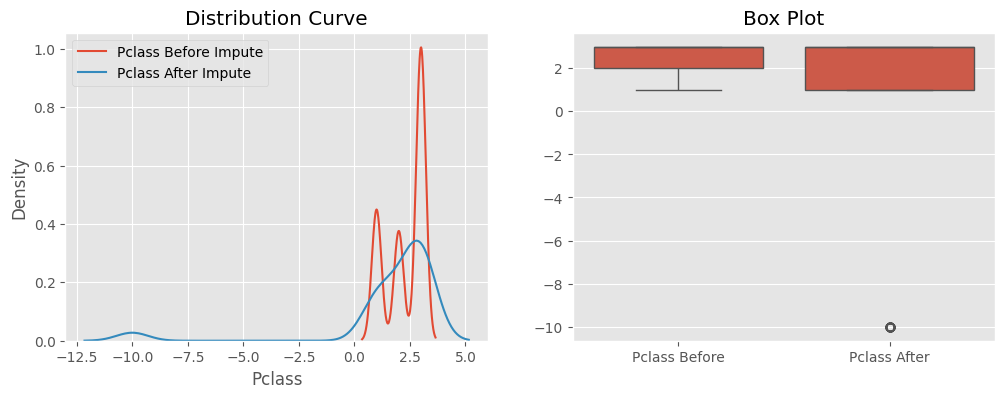

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.kdeplot(Arbitrary_data['Pclass'], label='Pclass Before Impute')
sns.kdeplot(Imputed_Data['Pclass'], label='Pclass After Impute')
plt.title('Distribution Curve')
plt.legend()

plt.subplot(122)
sns.boxplot({'Pclass Before':Arbitrary_data['Pclass']})
sns.boxplot({'Pclass After':Imputed_Data['Pclass']})
plt.title('Box Plot')

plt.show()

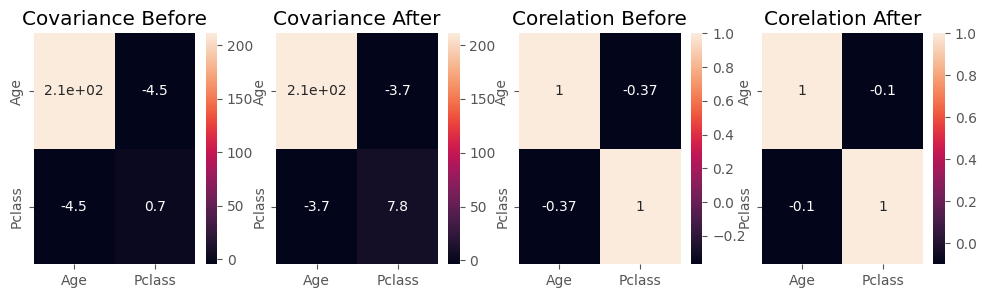

In [43]:
plt.figure(figsize=(12,3))
plt.subplot(141)
sns.heatmap(Arbitrary_data[Arbitrary_data.columns].cov(),annot=True)
plt.title("Covariance Before")
plt.subplot(142)
sns.heatmap(Imputed_Data[Arbitrary_data.columns].cov(),annot=True)
plt.title("Covariance After")
plt.subplot(143)
sns.heatmap(Arbitrary_data[Arbitrary_data.columns].corr(),annot=True)
plt.title("Corelation Before")
plt.subplot(144)
sns.heatmap(Imputed_Data[Arbitrary_data.columns].corr(),annot=True)
plt.title("Corelation After")

plt.show()

#### Defining Function for Arbitrary Imputes and Moniter It's impacts

In [44]:
def Arbitrary_Impute_func(data:pd.DataFrame,colls:(list,pd.Series,np.array),fill_value:(list,pd.Series,np.array)):
    if len(colls)!=len(fill_value):
        raise ValueError('ERROR: Length of columns is not equal to the Impute method mentioned')
    new_data = data[[col for col in data.columns if col not in colls]]
    for col, val in zip(colls,fill_value):
        si = SimpleImputer(strategy='constant',fill_value=val)
        new_data[col] = si.fit_transform(data[[col]])

    
    ss = StandardScaler()
    old_scaled = ss.fit_transform(data[colls])
    new_scaled = ss.transform(new_data[colls])
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    for i, coll in enumerate(colls):
        sns.kdeplot(old_scaled[:,i], label=f'{coll} before')
        sns.kdeplot(new_scaled[:,i], label=f'{coll} after')
    plt.title('Distribution Curve')
    plt.legend()
    
    plt.subplot(122)
    for i, coll in enumerate(colls):
        sns.boxplot({f'{coll} before': old_scaled[:,i]})
        sns.boxplot({f'{coll} after':new_scaled[:,i]})
    plt.title('Box Plot')

    plt.show()

    
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    sns.heatmap(data[data.columns].cov(),annot=True)
    plt.title("Covariance Before")
    plt.subplot(142)
    sns.heatmap(new_data[data.columns].cov(),annot=True)
    plt.title("Covariance After")
    plt.subplot(143)
    sns.heatmap(data[data.columns].corr(),annot=True)
    plt.title("Corelation Before")
    plt.subplot(144)
    sns.heatmap(new_data[data.columns].corr(),annot=True)
    plt.title("Corelation After")
    
    plt.show()

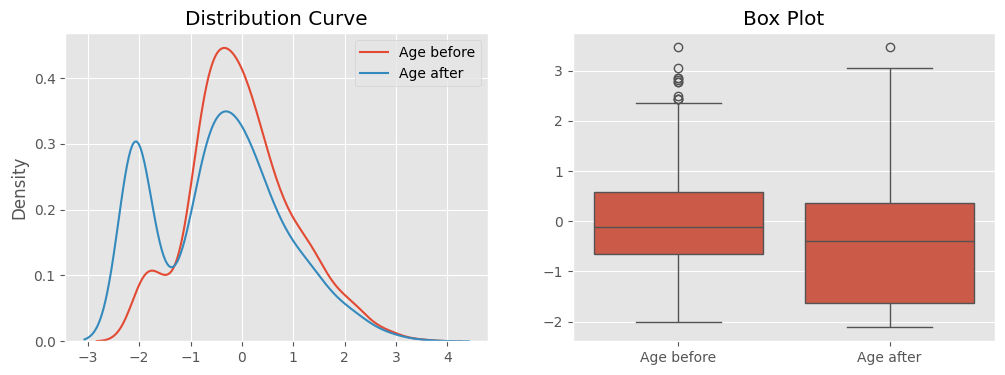

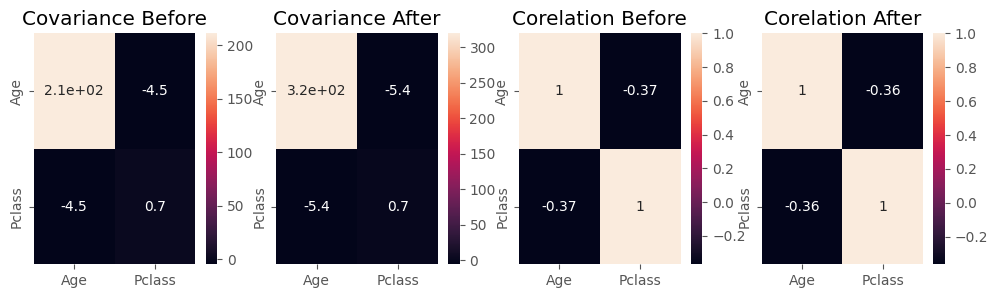

In [45]:
Arbitrary_Impute_func(Arbitrary_data,['Age'],[-1])

### End of Distribution
- Replace with
  - If Data Normaly Distribution
    - (mean + 3std) Or (mean - 3std)
  - If skewed Distribution
    - (Q1 - 1.5IQR) OR (Q3 + 1.5IQR)
- Use when our data is not randomly missing
- Change the distribution shape
- Create outliers which might not be a outliers before
- Change in Covariance and Corelation

In [46]:
EOF_Data = df[['Age','Pclass']]
EOF_Data.shape

(891, 2)

In [47]:
np.round(EOF_Data.isna().sum()/EOF_Data.shape[0]*100,2)

Age       19.87
Pclass     4.94
dtype: float64

#### Imputing in Age

In [60]:
Q1,Q3 = np.quantile(EOF_Data['Age'].dropna(),[0.25,0.75])
IQR = Q3 - Q1

In [63]:
EOF_Imputed = EOF_Data[['Pclass']]
EOF_Imputed['Age'] = EOF_Data['Age'].fillna(Q1-(1.5*IQR))

#### Comparing The Output

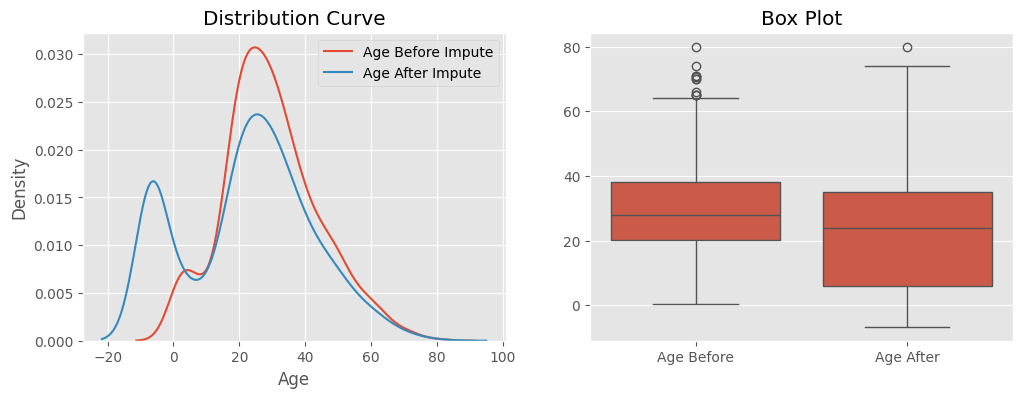

In [64]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.kdeplot(EOF_Data['Age'], label='Age Before Impute')
sns.kdeplot(EOF_Imputed['Age'], label='Age After Impute')
plt.title('Distribution Curve')
plt.legend()

plt.subplot(122)
sns.boxplot({'Age Before':EOF_Data['Age']})
sns.boxplot({'Age After':EOF_Imputed['Age']})
plt.title('Box Plot')

plt.show()

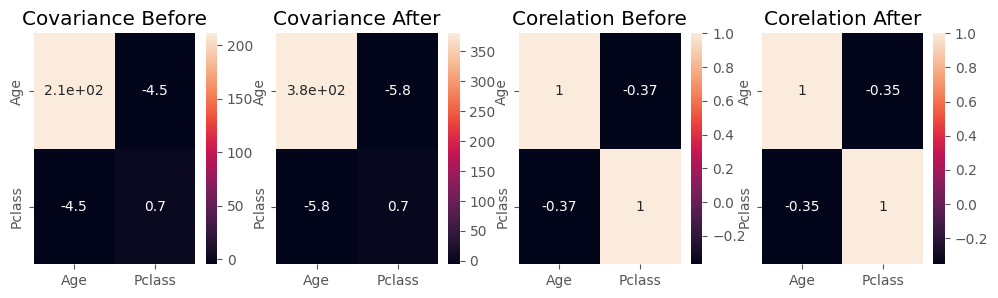

In [65]:
plt.figure(figsize=(12,3))
plt.subplot(141)
sns.heatmap(EOF_Data[EOF_Data.columns].cov(),annot=True)
plt.title("Covariance Before")
plt.subplot(142)
sns.heatmap(EOF_Imputed[EOF_Data.columns].cov(),annot=True)
plt.title("Covariance After")
plt.subplot(143)
sns.heatmap(EOF_Data[EOF_Data.columns].corr(),annot=True)
plt.title("Corelation Before")
plt.subplot(144)
sns.heatmap(EOF_Imputed[EOF_Data.columns].corr(),annot=True)
plt.title("Corelation After")

plt.show()

#### Defining Function for EOD Imputes and Moniter It's impacts

In [66]:
def EOD_Impute_func(data:pd.DataFrame,colls:(list,pd.Series,np.array),fill_value:(list,pd.Series,np.array)):
    if len(colls)!=len(fill_value):
        raise ValueError('ERROR: Length of columns is not equal to the Impute method mentioned')
    new_data = data[[col for col in data.columns if col not in colls]]
    for col, val in zip(colls,fill_value):
        if val == 'positive':
            Q1,Q3 = np.quantile(data[col].dropna(),[0.25,0.75])
            IQR = Q3 - Q1
            value = Q3+(1.5*IQR)
        elif val == 'nagative':
            Q1,Q3 = np.quantile(data[col].dropna(),[0.25,0.75])
            IQR = Q3 - Q1
            value = Q1-(1.5*IQR)
        else:
            raise ValueError('ERROR: Fill_value can only be series of "positive" and "nagative"')
        si = SimpleImputer(strategy='constant',fill_value=value)
        new_data[col] = si.fit_transform(data[[col]])

    
    ss = StandardScaler()
    old_scaled = ss.fit_transform(data[colls])
    new_scaled = ss.transform(new_data[colls])
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    for i, coll in enumerate(colls):
        sns.kdeplot(old_scaled[:,i], label=f'{coll} before')
        sns.kdeplot(new_scaled[:,i], label=f'{coll} after')
    plt.title('Distribution Curve')
    plt.legend()
    
    plt.subplot(122)
    for i, coll in enumerate(colls):
        sns.boxplot({f'{coll} before': old_scaled[:,i]})
        sns.boxplot({f'{coll} after':new_scaled[:,i]})
    plt.title('Box Plot')

    plt.show()

    
    plt.figure(figsize=(12,3))
    plt.subplot(141)
    sns.heatmap(data[data.columns].cov(),annot=True)
    plt.title("Covariance Before")
    plt.subplot(142)
    sns.heatmap(new_data[data.columns].cov(),annot=True)
    plt.title("Covariance After")
    plt.subplot(143)
    sns.heatmap(data[data.columns].corr(),annot=True)
    plt.title("Corelation Before")
    plt.subplot(144)
    sns.heatmap(new_data[data.columns].corr(),annot=True)
    plt.title("Corelation After")
    
    plt.show()

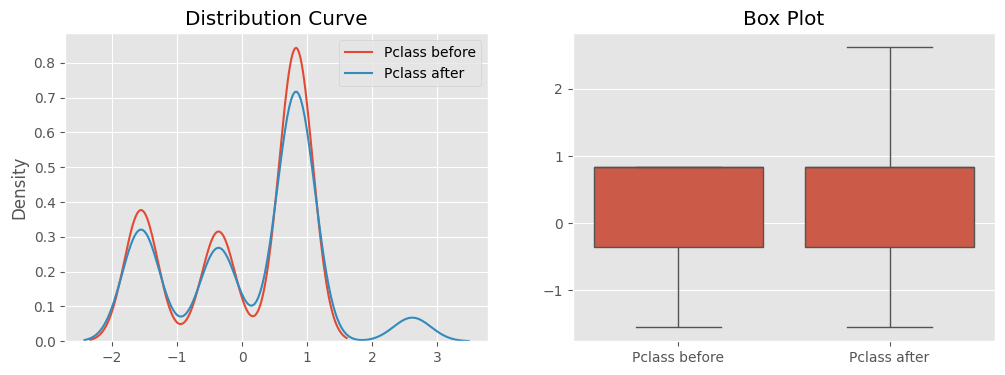

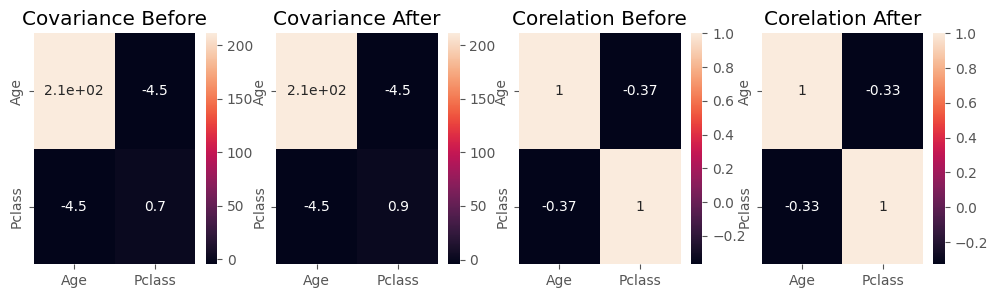

In [68]:
EOD_Impute_func(EOF_Data,['Pclass'],['positive'])

### Random